<img width="250" style="float:right" 
     src="https://cdn.i.haymarketmedia.asia/?n=campaign-asia%2Fcontent%2FcroppedF1logo.png&h=570&w=855&q=100&v=20170226&c=1" />

# Formula 1 Analysis

### Cassady Cook


# Sections

* [1. PySpark environment setup](#1)
  * [1.1 Search for Spark Installation](#1.1)  
  * [1.2 Create SparkSession](#1.2)
* [2. Data source and Spark data abstraction (DataFrame) setup](#2)
* [3. Data sets Meta Analysis](#3)
* [4. Machine Learning](#4)
  * [6.1 Feature Transformation](#6.1)
  * [6.2 Model Training & Selection](#6.2)
  * [6.3 Model Predictions](#6.3)

<a id='1'></a>
## 1. PySpark environment setup

To setup our PySpark environment we:
1. Search for Spark Installation
2. Create SparkSession

<a id='1.1'></a>
### 1.1 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()

We change pandas max column width property in order to improve data displaying.

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.2'></a>
### 1.2 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster

In [3]:
# To access catalogue in Hive
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

The first thing always is to create the SparkSession

In [4]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
    .appName("Twitter Analytics - DataFrames")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .config("spark.sql.legacy.timeParserPolicy","LEGACY")
    .enableHiveSupport()
    .getOrCreate())

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a6fccac6-7070-466c-b571-d91ac7373cf4;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 419ms :: artifacts dl 14ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	-----------------------------------------------------------

<a id='2'></a>
## 2. Data source and Spark data abstraction (DataFrame) setup


- In order to get an overview of the industry, we imported one merged file with data from 2014 to 2021.

We choose to infer the schema of the datasets as there is too many columns and datasets.

In [5]:
f1_main = spark.read.option("inferSchema", "true")\
                    .option("header", "true")\
                    .csv("f1_personal.csv")\
                    .cache() # optimization to make processing faster

In [6]:
f1_main.dtypes

[('season', 'int'),
 ('grand_prix_name', 'string'),
 ('name', 'string'),
 ('constructor', 'string'),
 ('qual_position', 'int'),
 ('track_name', 'string'),
 ('city', 'string'),
 ('country', 'string'),
 ('type', 'string'),
 ('finish_position', 'int'),
 ('points', 'int'),
 ('number_of_laps', 'int'),
 ('fastest_lap', 'int')]

In [7]:
f1_main.limit(5).toPandas()

,season,grand_prix_name,name,constructor,qual_position,track_name,city,country,type,finish_position,points,number_of_laps,fastest_lap
0,2014,australian,Nico Rosberg,mercedes,3,albert_park,Melbourne,Australia,Street circuit,1,25,57,1
1,2014,australian,Kevin Magnussen,mclaren,4,albert_park,Melbourne,Australia,Street circuit,2,18,57,0
2,2014,australian,Jenson Button,mclaren,11,albert_park,Melbourne,Australia,Street circuit,3,15,57,0
3,2014,australian,Fernando Alonso,ferrari,5,albert_park,Melbourne,Australia,Street circuit,4,12,57,0
4,2014,australian,Valtteri Bottas,williams,10,albert_park,Melbourne,Australia,Street circuit,5,10,57,0


In [8]:
f1_main.count()

3415

In [9]:
f1_main.filter(f1_main.season.isNull()).count()

8

In [10]:
f1_main.tail(8)

[Row(season=None, grand_prix_name=None, name=None, constructor=None, qual_position=None, track_name=None, city=None, country=None, type=None, finish_position=None, points=None, number_of_laps=None, fastest_lap=None),
 Row(season=None, grand_prix_name=None, name=None, constructor=None, qual_position=None, track_name=None, city=None, country=None, type=None, finish_position=None, points=None, number_of_laps=None, fastest_lap=None),
 Row(season=None, grand_prix_name=None, name=None, constructor=None, qual_position=None, track_name=None, city=None, country=None, type=None, finish_position=None, points=None, number_of_laps=None, fastest_lap=None),
 Row(season=None, grand_prix_name=None, name=None, constructor=None, qual_position=None, track_name=None, city=None, country=None, type=None, finish_position=None, points=None, number_of_laps=None, fastest_lap=None),
 Row(season=None, grand_prix_name=None, name=None, constructor=None, qual_position=None, track_name=None, city=None, country=None, t

Now that we know the length of the data is 3415 rows and there are 8 null rows, we need to take them out.

In [11]:
f1_main = f1_main.limit(3407)
f1_main.count()

3407

In [12]:
# There was one pesky null value that was not allowing the model to fit

f1_main = f1_main.filter("qual_position IS NOT NULL")
f1_main = f1_main.filter("points IS NOT NULL")

<a id='3'></a>
## 3. Data sets Meta Analysis

In [13]:
from IPython.display import display, Markdown
f1_main.printSchema()
display(Markdown("This F1 DataFrame has **%d rows**." % f1_main.count()))

root
 |-- season: integer (nullable = true)
 |-- grand_prix_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- constructor: string (nullable = true)
 |-- qual_position: integer (nullable = true)
 |-- track_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- type: string (nullable = true)
 |-- finish_position: integer (nullable = true)
 |-- points: integer (nullable = true)
 |-- number_of_laps: integer (nullable = true)
 |-- fastest_lap: integer (nullable = true)



This F1 DataFrame has **3405 rows**.

Here we are importing all the libraries for the further analysis.

In [14]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

### Has the number of races changed in the past 8 seasons?

In [15]:
numberRaces = f1_main[['season', 'grand_prix_name']]\
            .groupby('season')\
            .agg(F.countDistinct('grand_prix_name')\
            .alias('races'))\
            .sort(F.col('season').asc()).toPandas()
numberRaces

,season,races
0,2014,19
1,2015,19
2,2016,21
3,2017,20
4,2018,21
5,2019,21
6,2020,17
7,2021,21
8,2022,8


Text(0, 0.5, '# of Races')

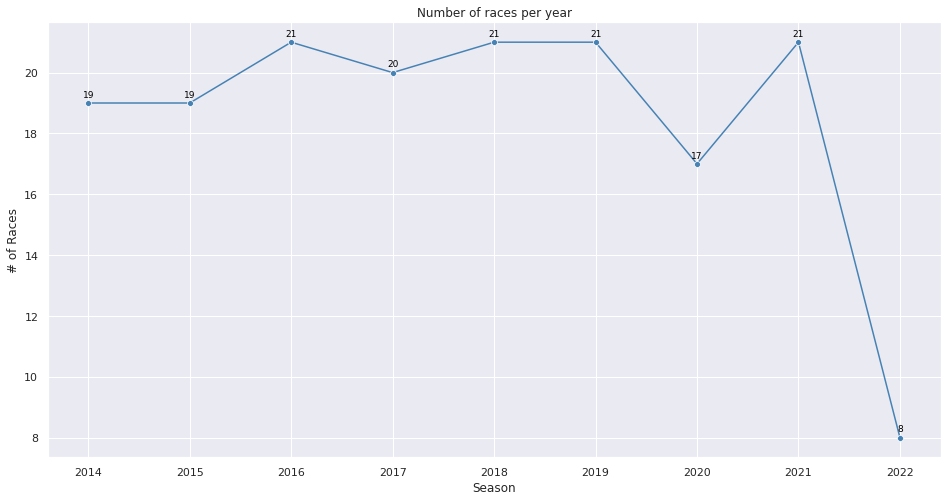

In [16]:
plt.figure(figsize=(16, 8))
sns.set(style="darkgrid")
sns.lineplot(x="season", y="races", data=numberRaces, color="steelblue", marker="o")
# adding chart title
plt.title('Number of races per year')

# adding labels on bar chart
for index, row in numberRaces.iterrows():
    plt.text(row.season, row.races + 0.2, row.races, color='black', ha="center", size=9)
    
# adding custom labels for axes
plt.xlabel("Season")
plt.ylabel("# of Races")

The 2020 Season was drastically effected by Covid19

## Which driver has won the most races?

In [17]:
most_races = f1_main.groupBy('name').agg(F.count('finish_position')\
        .alias("races"))\
        .sort(F.col('races').desc()).toPandas()
        #.filter(F.col('first_place_finish') == 1).toPandas()
most_races.head(10)

,name,races
0,Valtteri Bottas,167
1,Daniel Ricciardo,167
2,Lewis Hamilton,166
3,Sergio Perez,165
4,Sebastian Vettel,165
5,Kimi Raikkonen,157
6,Carlos Sainz,148
7,Max Verstappen,148
8,Romain Grosjean,136
9,Kevin Magnussen,128


In [18]:
#df.filter(df.state == "OH").show(truncate=False)
winners = f1_main.filter(f1_main.finish_position == 1)
winners.toPandas()

winners_sorted = winners.groupby('name').agg(F.count('*')\
        .alias('first_place'))\
        .sort(F.col('first_place').desc()).toPandas()

winners_sorted

,name,first_place
0,Lewis Hamilton,80
1,Max Verstappen,25
2,Nico Rosberg,20
3,Sebastian Vettel,14
4,Valtteri Bottas,10
5,Daniel Ricciardo,8
6,Charles Leclerc,4
7,Sergio Perez,3
8,Kimi Raikkonen,1
9,Pierre Gasly,1


<a id='4'></a>
## 6. Machine Learning


With the `f1_main` data we are now creating a model to predict the points earned for each driver at the end of a race. <br/>
We will validate our model with the real race data from a finished race.

In [19]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import *
from pyspark.sql.functions import *
import copy
from pyspark.sql.types import *
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC

In [20]:
f1_main.dtypes

[('season', 'int'),
 ('grand_prix_name', 'string'),
 ('name', 'string'),
 ('constructor', 'string'),
 ('qual_position', 'int'),
 ('track_name', 'string'),
 ('city', 'string'),
 ('country', 'string'),
 ('type', 'string'),
 ('finish_position', 'int'),
 ('points', 'int'),
 ('number_of_laps', 'int'),
 ('fastest_lap', 'int')]

In [21]:
#f1_main = f1_main.withColumn('fastest_lap', f1_main.fastest_lap.cast('boolean'))

In [22]:
f1_main.limit(2).toPandas().T

,0,1
season,2014,2014
grand_prix_name,australian,australian
name,Nico Rosberg,Kevin Magnussen
constructor,mercedes,mclaren
qual_position,3,4
track_name,albert_park,albert_park
city,Melbourne,Melbourne
country,Australia,Australia
type,Street circuit,Street circuit
finish_position,1,2


First we label our target variable

In [23]:
label_columns = 'points'

In [24]:
f1_main.columns

['season',
 'grand_prix_name',
 'name',
 'constructor',
 'qual_position',
 'track_name',
 'city',
 'country',
 'type',
 'finish_position',
 'points',
 'number_of_laps',
 'fastest_lap']

<a id='6.1'></a>
## 6.1 Feature Transformation

Now we separate into categorical and numerical columns

In [25]:
cat_cols = [field for (field, dataType)\
                   in f1_main.dtypes\
                   if ((dataType == "string") | (dataType == 'int')\
                       & (field in ('grand_prix_name', 'constructor', 'country', 'city', 'type', 'season', 'track_name', 'name')))]
    #'direction', 'country', 'locality', 'type', 'season', 'round', 'qual_position', 'grid', 'race_name')))]



num_cols = [field for (field, dataType) in f1_main.dtypes\
               if ((dataType == 'int')\
                   & (field in ('number_of_laps', 'qual_position')))]
    #'q_mean', 'q_best', 'q_worst', 'length', 'ageDuringRace', 'finish_position', 'filled_splits')))]
                       


print (f"categorical columns: {cat_cols}")
print (f"numerical columns: {num_cols}")

categorical columns: ['season', 'grand_prix_name', 'name', 'constructor', 'track_name', 'city', 'country', 'type']
numerical columns: ['qual_position', 'number_of_laps']


In [26]:
indexers = [StringIndexer(inputCol = c, outputCol="{0}_indexed".format(c)) for c in cat_cols]

In [27]:
## ME

#indexer = [StringIndexer(inputCol = c, outputCol ="{0}_indexed".format(c)) for c in cat]
#indexer
pd.options.display.max_columns = None

#_show = f1_main.filter("qual_position IS NOT NULL")#.where(col('qual_position') == None)
#_show_pandas =_show.toPandas()
#_show_pandas[_show_pandas['qual_position'].isna() == True]
#_show.describe().toPandas()

We need to encode the categorical columns

In [28]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
outputCol=["{0}_indexed".format(c) for c in cat_cols]
outputCol_enc = ["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers ]
stringIndexer = StringIndexer(inputCols=cat_cols, outputCols=outputCol, handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=outputCol,outputCols=outputCol_enc)

We created a vector for the encoded categorical columns

In [29]:
in_col_assembler = [e for e in outputCol_enc]

cat_col_assembler = VectorAssembler(inputCols = in_col_assembler, outputCol = 'categorical')

in_col_assembler

['season_indexed_encoded',
 'grand_prix_name_indexed_encoded',
 'name_indexed_encoded',
 'constructor_indexed_encoded',
 'track_name_indexed_encoded',
 'city_indexed_encoded',
 'country_indexed_encoded',
 'type_indexed_encoded']

We create a pipeline for the categorical columns and fit it to the F1 main Dataset

In [30]:
pipeline_cat = Pipeline(stages = [stringIndexer, oheEncoder, cat_col_assembler])
f1_main = pipeline_cat.fit(f1_main).transform(f1_main)

We need to scale the numerical columns

In [31]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline

columns_to_scale = ['number_of_laps', 'qual_position']
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(f1_main)
#scaledData = scalerModel.transform(train)

f1_main = scalerModel.transform(f1_main)
f1_main.columns

['season',
 'grand_prix_name',
 'name',
 'constructor',
 'qual_position',
 'track_name',
 'city',
 'country',
 'type',
 'finish_position',
 'points',
 'number_of_laps',
 'fastest_lap',
 'country_indexed',
 'season_indexed',
 'city_indexed',
 'name_indexed',
 'type_indexed',
 'constructor_indexed',
 'grand_prix_name_indexed',
 'track_name_indexed',
 'grand_prix_name_indexed_encoded',
 'country_indexed_encoded',
 'city_indexed_encoded',
 'type_indexed_encoded',
 'name_indexed_encoded',
 'constructor_indexed_encoded',
 'track_name_indexed_encoded',
 'season_indexed_encoded',
 'categorical',
 'number_of_laps_vec',
 'qual_position_vec',
 'number_of_laps_scaled',
 'qual_position_scaled']

In [32]:
#in_num_assembler = ['q_best_scaled',
# 'q_worst_scaled',
# 'q_mean_scaled',
# 'ageDuringRace_scaled',
# 'length_scaled',
# 'filled_splits_scaled',
# 'finish_position_scaled']

in_num_assembler = ['number_of_laps_scaled',
                    'qual_position']


in_num_assembler

['number_of_laps_scaled', 'qual_position']

Now we create a vector for the numerical columns

In [33]:
assemblerNum = VectorAssembler(inputCols = in_num_assembler, outputCol = "num")

We create a Pipeline for the numerical columns and fit it to the f1 main Dataset

In [34]:
pipelineNum = Pipeline(stages = [assemblerNum])
f1_main = pipelineNum.fit(f1_main).transform(f1_main)

Finally we create an additional vector assembler for both categorical and numerical columns that outputs are features

In [35]:
assembler = VectorAssembler(inputCols = ["categorical", "num"], outputCol = "features")

<a id='6.2'></a>
## 6.2 Model Training & Selection

Now we split the Dataset to Train and Test

In [36]:
#train = f1_main.filter(f1_main.season < 2022)
#test = f1_main.filter(f1_main.season == 2022)


In [37]:
seed = 42
(train, test) = f1_main.filter(f1_main.season != 2022).randomSplit([0.8,0.2],seed=seed)

test2022 = f1_main.filter(f1_main.season == 2022)

In [38]:
type(train)

pyspark.sql.dataframe.DataFrame

Now we are going to test different algorithms and we will choose the one with the best evaluator score for our data

In [39]:
l = LinearRegression(labelCol = 'points', featuresCol = 'features')
lr = LogisticRegression(labelCol='points', featuresCol="features")
nb = NaiveBayes(labelCol='points', featuresCol="features")
svm = LinearSVC(labelCol='points', featuresCol="features")
rfr = RandomForestRegressor(labelCol= 'points', featuresCol = 'features', numTrees=2000)

**Linear regression**

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator
l_pipeline = Pipeline(stages = [assembler,l])
l_model = l_pipeline.fit(train)
l_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'points', metricName = 'r2')

In [41]:
prediction_l = l_model.transform(test)
r2_l = l_evaluator.evaluate(prediction_l)
r2_l

0.5787554334802506

**Logistic regression**

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr_pipeline = Pipeline(stages = [assembler, lr])
lr_model = lr_pipeline.fit(train)
lr_evaluator = MulticlassClassificationEvaluator(labelCol="points",  metricName="accuracy")

In [43]:
prediction_lr = lr_model.transform(test)
accuracy_lr = lr_evaluator.evaluate(prediction_lr)
accuracy_lr

0.5042016806722689

**Naive Bayes**

In [44]:
nb_pipeline = Pipeline(stages = [assembler,nb])
nb_model = nb_pipeline.fit(train)
evaluator_nb = MulticlassClassificationEvaluator(labelCol="points",  metricName="accuracy")

In [45]:
prediction_nb = nb_model.transform(test)
accuracy_nb = evaluator_nb.evaluate(prediction_nb)
accuracy_nb

0.4638655462184874

**Random Forest**

In [46]:
rf_pipeline = Pipeline(stages = [assembler, rfr])
rf_model = rf_pipeline.fit(train)
evaluator_rf = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'points', metricName = 'r2')

In [47]:
prediction_rf = rf_model.transform(test)
accuracy_rf = evaluator_rf.evaluate(prediction_rf)
accuracy_rf

0.6103570836675208

We are selecting the linear regression and random forest resgressor as our models

<a id='6.3'></a>
## 6.3 Model Predictions

Now that we run 4 models we are going to show the predictions for linear regression and random forest

Linear regression predictions

In [56]:
predict_l = l_model.transform(test2022)
r2_l = l_evaluator.evaluate(predict_l)
r2_l


0.39863037011514424

In [60]:
predict_l.select(col('name'), 
                     col('grand_prix_name'), 
                     col('constructor'),
                     col('qual_position'), 
                     col('finish_position'), 
                     col('points'), 
                     col('prediction'))\
                    .limit(5).toPandas().T

,0,1,2,3,4
name,Charles Leclerc,Carlos Sainz,Lewis Hamilton,George Russell,Kevin Magnussen
grand_prix_name,bahrain,bahrain,bahrain,bahrain,bahrain
constructor,ferrari,ferrari,mercedes,mercedes,haas
qual_position,1,3,5,9,7
finish_position,1,2,3,4,5
points,26,18,15,12,10
prediction,10.413063,10.884899,18.667715,6.500918,3.636327


Random Forest Predictions

In [61]:
predict_rf = rf_model.transform(test2022)
accuracy_rf = evaluator_rf.evaluate(predict_rf)
accuracy_rf

0.5083241299506596

In [62]:
predict_rf.select(col('name'), 
                     col('grand_prix_name'), 
                     col('constructor'),
                     col('qual_position'), 
                     col('finish_position'), 
                     col('points'), 
                     col('prediction'))\
                    .limit(5).toPandas().T

,0,1,2,3,4
name,Charles Leclerc,Carlos Sainz,Lewis Hamilton,George Russell,Kevin Magnussen
grand_prix_name,bahrain,bahrain,bahrain,bahrain,bahrain
constructor,ferrari,ferrari,mercedes,mercedes,haas
qual_position,1,3,5,9,7
finish_position,1,2,3,4,5
points,26,18,15,12,10
prediction,13.067675,11.325574,16.710867,8.814013,3.135298


# Takeaways

## How can I improve my model?

- Learn multi-class classification to predict finish_positions
- Run param_grid on parameters for regression
- 